In [1]:
import pandas as pd
import gmaps as gp
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
properati = pd.read_csv('datos/properati_2.csv')
len(properati)

121220

In [3]:
properati.columns

Index([u'Unnamed: 0', u'id', u'created_on', u'operation', u'property_type',
       u'place_name', u'place_with_parent_names', u'country_name',
       u'state_name', u'geonames_id', u'lat-lon', u'lat', u'lon', u'price',
       u'currency', u'price_aprox_local_currency', u'price_aprox_usd',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'price_usd_per_m2',
       u'price_per_m2', u'floor', u'rooms', u'expenses', u'properati_url',
       u'description', u'title', u'image_thumbnail', u'region', u'localidad',
       u'ciudad', u'barrio'],
      dtype='object')

In [4]:
#Saco algunas columnas que no parecen servir
filtrado = properati.drop( ['id','operation','title','description','image_thumbnail','properati_url','property_type',
                            'country_name','state_name','place_name','lat-lon','geonames_id'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
filtrado.dropna(how='all',inplace=True)
filtrado.head(10)

,Unnamed: 0,created_on,place_with_parent_names,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
0,0,2017-02-01,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
1,1,2017-02-01,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,-34.903883,-57.964329,150000.0,USD,2646675.00,150000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bs.As. G.B.A. Zona Sur,La Plata,NaN,NaN
2,2,2017-02-01,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.00,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
3,3,2017-02-01,|Argentina|Capital Federal|Liniers|,-34.647797,-58.516424,95000.0,USD,1676227.50,95000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Capital Federal,Liniers,NaN,NaN
4,4,2017-02-01,|Argentina|Buenos Aires Costa Atlántica|Mar de...,-38.002626,-57.549447,64000.0,USD,1129248.00,64000.00,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,Buenos Aires Costa Atlántica,Mar del Plata,Centro,NaN
5,5,2017-02-01,|Argentina|Entre Ríos|Gualeguaychú|,-33.014071,-58.519828,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,Entre Ríos,Gualeguaychú,NaN,NaN
6,6,2017-02-01,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,-34.532957,-58.521783,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,NaN
7,7,2017-02-01,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
8,8,2017-02-01,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
9,9,2017-02-01,|Argentina|Santa Fe|Rosario|,-32.942031,-60.725919,460000.0,ARS,455201.45,25798.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Santa Fe,Rosario,NaN,NaN


In [5]:
#separo place_with_parent_names, tarda bastante
#separado = filtrado['place_with_parent_names'].apply(lambda x: pd.Series(x.split('|')))
# estaria bueno que las columnas tengan el nombre que corresponde y la 0 no tenga nombre
#separado.columns = ['a','pais', 'region','localidad','ciudad','barrio','aborrar'] #mejorar
#separado = separado.drop(['a','pais','aborrar'],1) # mejorar
#separado.head(10)

In [6]:
#Uno las columnas nuevas en el set filtrado
#filtrado = pd.concat([filtrado, separado], axis=1)
filtrado.drop('place_with_parent_names',1,inplace=True)

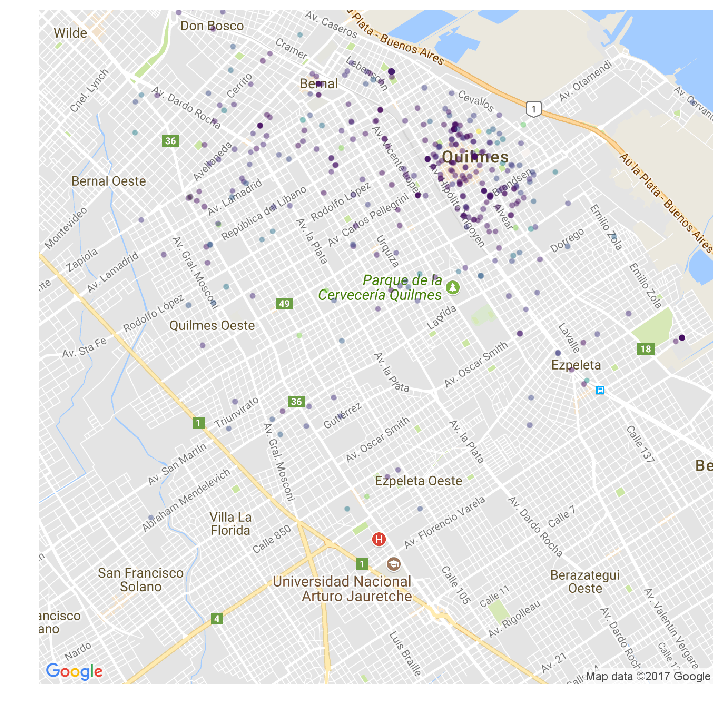

In [7]:
#solo para probar si funcionaba
cap=filtrado.loc[(filtrado['localidad'] == 'Quilmes')] 
gp.scatter(cap['lat'], cap['lon'],cap['surface_total_in_m2'])

In [8]:
filtrado = filtrado.dropna(subset=['price'])  

In [9]:
ranking_precios_usd = filtrado.groupby('region').mean()['price_usd_per_m2'].sort_values(ascending=False)

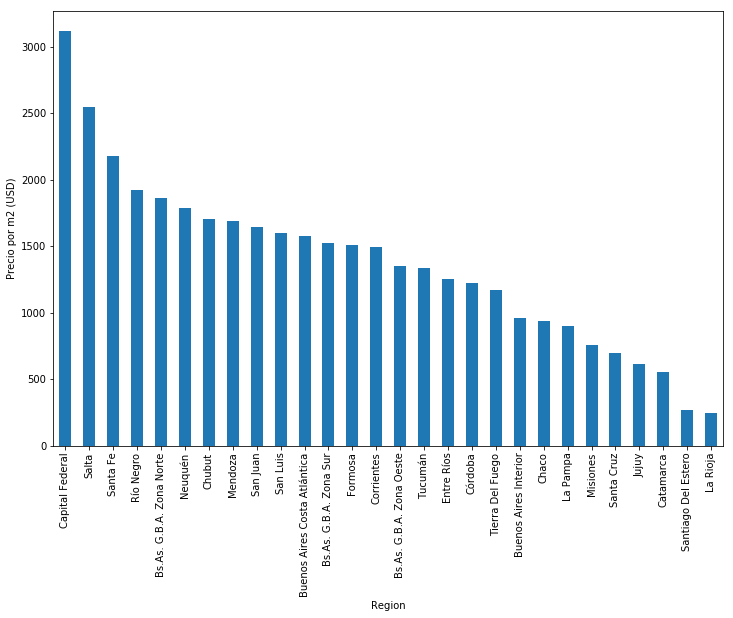

In [10]:
import matplotlib.pyplot as plt
ranking_precios_usd.plot(kind='bar',figsize=(12,8))
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

#### salta en segundo lugar. Investigo por que

In [11]:
salta = filtrado.loc[filtrado['region'] == 'Salta'].sort_values('price_usd_per_m2',ascending = False)
salta

,Unnamed: 0,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
25343,25343,2017-04-28,-24.791039,-65.411225,2850000.0,USD,50286825.00,2850000.00,120.0,120.0,23750.000000,23750.000000,NaN,4.0,NaN,Salta,Salta,NaN,NaN
26737,26737,2017-04-28,-24.782439,-65.445556,2800000.0,USD,49404600.00,2800000.00,150.0,160.0,18666.666667,17500.000000,NaN,5.0,NaN,Salta,Salta,NaN,NaN
25561,25561,2017-04-28,-24.834989,-65.429807,1100000.0,USD,19408950.00,1100000.00,65.0,65.0,16923.076923,16923.076923,NaN,4.0,NaN,Salta,Salta,NaN,NaN
26738,26738,2017-04-28,-24.780039,-65.445389,2600000.0,USD,45875700.00,2600000.00,155.0,130.0,16774.193548,20000.000000,NaN,5.0,NaN,Salta,Salta,NaN,NaN
25163,25163,2017-04-28,-24.794442,-65.415589,2800000.0,USD,49404600.00,2800000.00,170.0,120.0,16470.588235,23333.333333,NaN,5.0,NaN,Salta,Salta,NaN,NaN
26619,26619,2017-04-28,-24.842185,-65.436251,2500000.0,USD,44111250.00,2500000.00,250.0,170.0,10000.000000,14705.882353,NaN,5.0,NaN,Salta,Salta,NaN,NaN
99227,99227,2017-07-19,NaN,NaN,1200000.0,USD,21173400.00,1200000.00,500.0,500.0,2400.000000,2400.000000,NaN,NaN,NaN,Salta,La Caldera,NaN,NaN
78043,78043,2017-07-19,NaN,NaN,250000.0,USD,4411125.00,250000.00,114.0,NaN,2192.982456,NaN,NaN,NaN,4100.0,Salta,NaN,NaN,NaN
78143,78143,2017-07-19,NaN,NaN,1500000.0,ARS,1484352.56,84125.51,44.0,44.0,1911.943409,34090.909091,NaN,NaN,NaN,Salta,NaN,NaN,NaN
18497,18497,2017-04-06,-24.789827,-65.428404,1686088.0,ARS,1668499.38,94562.01,51.0,51.0,1854.157059,33060.549020,NaN,NaN,NaN,Salta,Salta,NaN,NaN


#### Las 6 primeras filas tienen precios altos en comparacion, tienen bien el precio?
La primer y la tercer fila tiene el mismo precio por m2 en pesos que en usd

La cuarta, quinta y la sexta tiene el precio en pesos mas alto que en dolares

Hay que filtrar todos esos casos

#### Filtro las propiedades cuyos precios tengan incoherencias

In [12]:
filtrado

,Unnamed: 0,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
0,0,2017-02-01,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
1,1,2017-02-01,-34.903883,-57.964329,150000.0,USD,2646675.00,150000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bs.As. G.B.A. Zona Sur,La Plata,NaN,NaN
2,2,2017-02-01,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.00,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
3,3,2017-02-01,-34.647797,-58.516424,95000.0,USD,1676227.50,95000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Capital Federal,Liniers,NaN,NaN
4,4,2017-02-01,-38.002626,-57.549447,64000.0,USD,1129248.00,64000.00,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,Buenos Aires Costa Atlántica,Mar del Plata,Centro,NaN
6,6,2017-02-01,-34.532957,-58.521783,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,NaN
7,7,2017-02-01,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
8,8,2017-02-01,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
9,9,2017-02-01,-32.942031,-60.725919,460000.0,ARS,455201.45,25798.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Santa Fe,Rosario,NaN,NaN
10,10,2017-02-01,-31.420083,-64.188776,70000.0,USD,1235115.00,70000.00,1514.0,NaN,46.235139,NaN,NaN,NaN,NaN,Córdoba,Córdoba,NaN,NaN


In [13]:
filtrado2 = filtrado.loc[(filtrado['price_per_m2'] > filtrado['price_usd_per_m2'])] #Esta borrando los NaN, no es la idea, pueden llegar a servir
filtrado2

,Unnamed: 0,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
0,0,2017-02-01,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
6,6,2017-02-01,-34.532957,-58.521783,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,NaN
7,7,2017-02-01,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
8,8,2017-02-01,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
12,12,2017-02-01,-34.486019,-58.503814,115000.0,USD,2029117.50,115000.00,39.0,36.0,2948.717949,3194.444444,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,San Isidro,Martínez,NaN
13,13,2017-02-01,NaN,NaN,111700.0,USD,1970890.65,111700.00,50.0,30.0,2234.000000,3723.333333,NaN,1.0,NaN,Capital Federal,Palermo,Palermo Soho,NaN
14,14,2017-02-01,NaN,NaN,147900.0,USD,2609621.55,147900.00,42.0,31.0,3521.428571,4770.967742,NaN,1.0,NaN,Capital Federal,Palermo,Palermo Soho,NaN
16,16,2017-02-01,-34.652356,-58.501624,239000.0,USD,4217035.50,239000.00,140.0,98.0,1707.142857,2438.775510,NaN,4.0,NaN,Capital Federal,Mataderos,NaN,NaN
17,17,2017-02-01,-34.408717,-58.634389,315000.0,USD,5558017.50,315000.00,176.0,78.0,1789.772727,4038.461538,NaN,3.0,NaN,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,Barrio El Golf
19,19,2017-02-01,-34.580504,-58.405874,350000.0,USD,6175575.00,350000.00,104.0,96.0,3365.384615,3645.833333,NaN,3.0,NaN,Capital Federal,Palermo,NaN,NaN


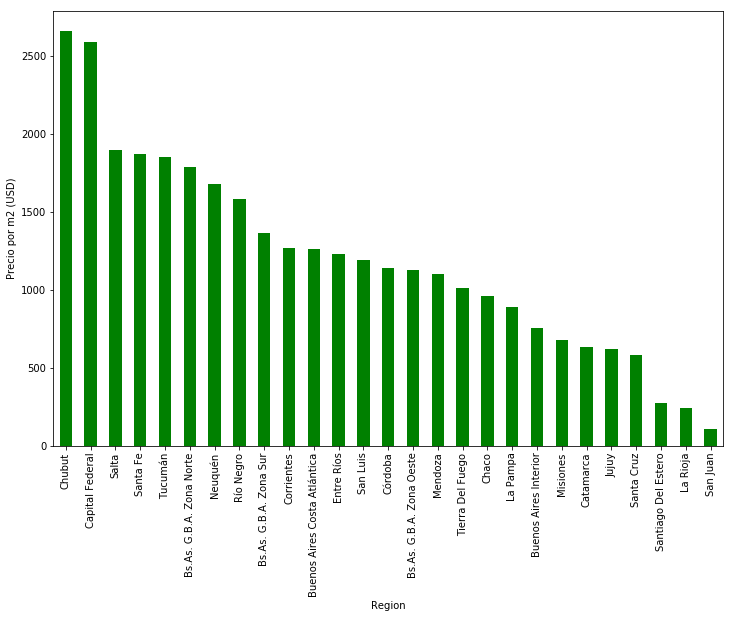

In [14]:
ranking_precios_usd = filtrado2.groupby('region').mean()['price_usd_per_m2'].sort_values(ascending=False)
ranking_precios_usd.plot(kind='bar',figsize=(12,8),color='g')
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

#### Tiene coherencia?

#### Otra demostracion de los datos erroneos en los precios. Deberia ser parecido al grafico en USD

In [15]:
ranking_precios_usd = filtrado2.groupby('region').mean()['price_usd_per_m2']
ranking_precios_ars = filtrado2.groupby('region').mean()['price_per_m2']

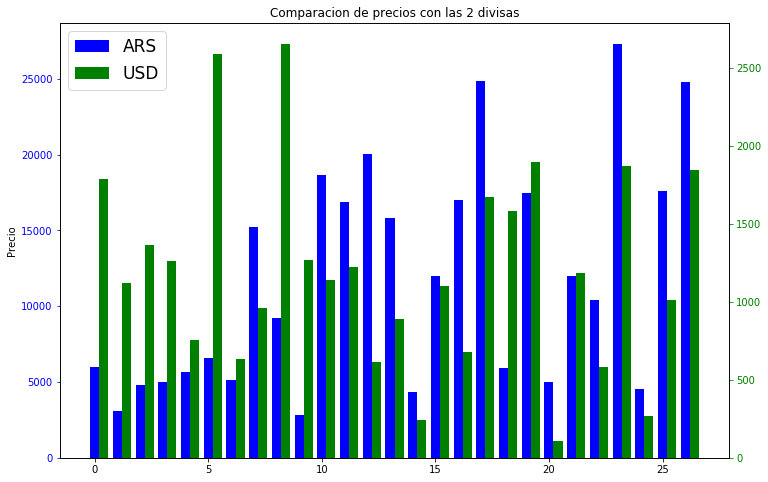

In [16]:
N = filtrado2.region.drop_duplicates().count()

ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig, ax1 = plt.subplots(figsize=(12,8))
ars= ax1.bar(ind, ranking_precios_ars, width, color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
usd = ax2.bar(ind + width, ranking_precios_usd, width, color='g')
ax2.tick_params('y', colors='g')

# add some text for labels, title and axes ticks
ax1.set_ylabel('Precio')
ax1.set_title('Comparacion de precios con las 2 divisas')
#ax.set_xticks(ind + width / 2)
#ax1.set_xticklabels(filtrado2.region.drop_duplicates().values) #funcionaria si no fuera por los acentos

ax1.legend((ars, usd), ('ARS', 'USD'),fontsize = 17)
plt.show()